# Orientation of the nuclei

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tifffile
from skimage.measure import label, regionprops

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Functions

In [ ]:
def orientation_nucleus(im_labeled,show=False,bins=10):
    
    nb_cells = len(np.unique(im_labeled))-1
    
    stats = regionprops(im_labeled)
    orientation_tab = np.zeros(nb_cells)
    for idx in range(nb_cells):
        orientation_tab[idx] = stats[idx]["orientation"]*180/np.pi
    
    if show:
        plt.hist(orientation_tab,bins=bins,range=(-90,90),edgecolor="black")
        plt.show()
    
    return orientation_tab

In [ ]:
def hist_orientation(im_labeled,show=False,bins=10):
  orientation_tab = orientation_nucleus(im_labeled,show,bins=bins)

  val,edges = np.histogram(orientation_tab,bins=bins,range=(-90,90))
  return val,edges

In [ ]:
def get_all_angle(path,bins):
  filelist = os.listdir(path)
  name_list = []

  for file_name in filelist : 
    name_list.append(file_name[:-4]) #get rid of the '.tif'
  name_list = np.array(name_list)
  
  angle_tab = []
  for k in range(len(name_list)):
      im = tifffile.imread(path+name_list[k]+".tif").astype(np.int32)
      orientation_image = list(orientation_nucleus(im,show=False,bins=bins))
      angle_tab += orientation_image
  return np.array(angle_tab)

In [ ]:
def get_most_common_orientation(val,edges,nb_orientation):
 idx = np.argsort(val)[::-1]
 most_commmon_angle = edges[idx][:nb_orientation]
 return most_commmon_angle

In [ ]:
def compute_orientation_database(path,nb_orientation,bins):
  
  filelist = os.listdir(path)
  name_list = []

  for file_name in filelist : 
    name_list.append(file_name[:-4]) #get rid of the '.tif'
  name_list = np.array(name_list)
  
  angle_tab = np.zeros((len(name_list),nb_orientation))
  for k in range(len(name_list)):
      im = tifffile.imread(path+name_list[k]+".tif").astype(np.int32)
      val,edges = hist_orientation(im,show=False,bins=bins)
      angle_tab[k] = get_most_common_orientation(val,edges,nb_orientation)
  df = pd.DataFrame(angle_tab)
  df.index = name_list
  return df

## Some examples

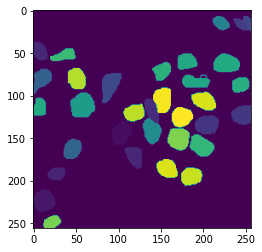

In [ ]:
imname = "TCGA-2Z-A9J9-01A-01-TS1_0"
im = tifffile.imread("/content/drive/MyDrive/IMA207/data/patch_gt_test/"+imname+".tif").astype(np.int32)
plt.imshow(im)

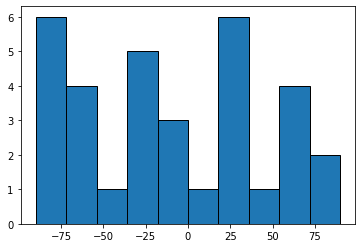

In [ ]:
val,edges = hist_orientation(im,show=True,bins=10)

<BarContainer object of 10 artists>

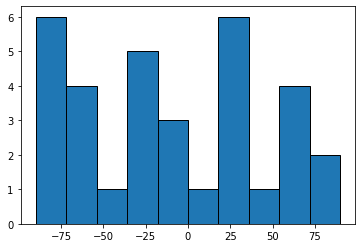

In [ ]:
plt.bar(edges[:-1],val,width = np.diff(edges),edgecolor="black",align="edge")

[  0. -18.]


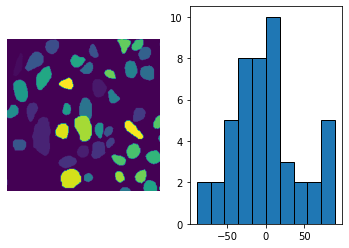

[72.  0.]


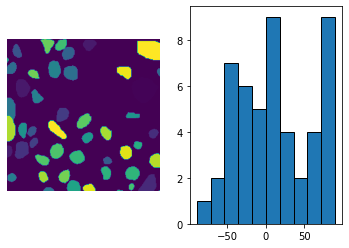

[-18.   0.]


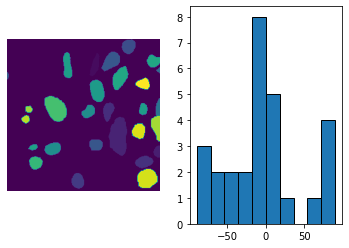

In [ ]:
path = "/content/drive/MyDrive/IMA207/data/patch_gt_test/"
filelisr = os.listdir(path)

for k in range(3):
    im1 = tifffile.imread(path+filelisr[k]).astype(np.int32)
    val,edges = hist_orientation(im1,show=False,bins=10)
    print(get_most_common_orientation(val,edges,2))
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(im1)
    ax[0].axis('off')
    ax[1].bar(edges[:-1],val,width = np.diff(edges),edgecolor="black",align="edge")
    plt.show()

## Computing the angle on the database

In [ ]:
path_train = "/content/drive/MyDrive/IMA207/data/patch_gt_train/"
path_test = "/content/drive/MyDrive/IMA207/data/patch_gt_test/"

bins = 18
nb_angles_to_keep = 4

df_train = compute_orientation_database(path_train,nb_angles_to_keep,bins)
df_test = compute_orientation_database(path_test,nb_angles_to_keep,bins)

In [ ]:
all_angles_train = get_all_angle(path_train,bins)

### Exporting

In [ ]:
df_train.to_csv("/content/drive/MyDrive/IMA207/data/train_orientation.csv")
df_test.to_csv("/content/drive/MyDrive/IMA207/data/test_orientation.csv")

In [ ]:
np.save("/content/drive/MyDrive/IMA207/data/all_angles_train.npy",all_angles_train)

## Analysis of the data

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/IMA207/data/train_orientation.csv",index_col=0)
df_test = pd.read_csv("/content/drive/MyDrive/IMA207/data/test_orientation.csv",index_col=1)

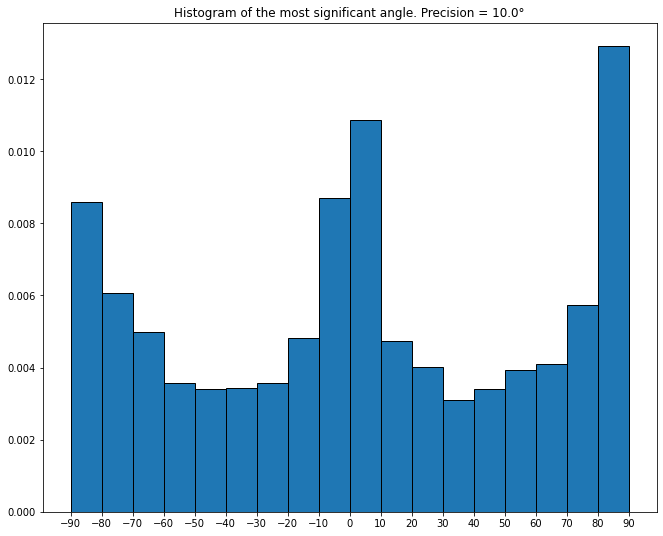

The most significant angles are 80.0 0.0 -10.0 and -90.0 degrees.
The least significant angles are 30.0 -50.0 and 40.0 degrees.


In [ ]:
all_angles_signi = np.array(df_train).flatten()

plt.figure(figsize=(11,9))
val,edges,_ = plt.hist(all_angles_signi,range=(-90,90),bins=bins,density=True,edgecolor="black",align="mid")
plt.xticks(edges)
plt.title("Histogram of the most significant angle. Precision = "+str(180/bins)+"°")
plt.savefig("Histogram_of_the_most_significant_angles_Precision_"+str(180/bins)+"degrees.png")
plt.show()

idx = np.argsort(val)[::-1]
print("The most significant angles are",edges[idx][0],edges[idx][1],edges[idx][2],"and",edges[idx][3],"degrees.")
print("The least significant angles are",edges[idx][-1],edges[idx][-2],"and",edges[idx][-3],"degrees.")

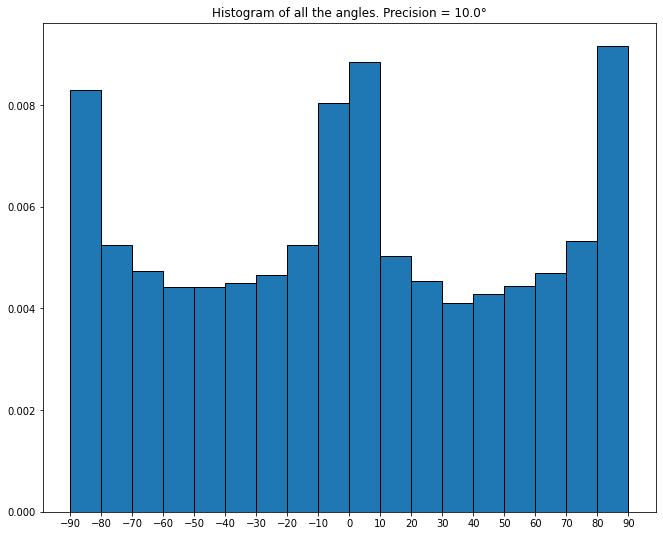

The most significant angles are 80.0 0.0 -90.0 and -10.0 degrees.
The least significant angles are 30.0 40.0 and -60.0 degrees.


In [ ]:
all_angles = np.load("/content/drive/MyDrive/IMA207/data/all_angles_train.npy")

plt.figure(figsize=(11,9))
val,edges,_ = plt.hist(all_angles,range=(-90,90),bins=bins,density=True,edgecolor="black",align="mid")
plt.xticks(edges)
plt.title("Histogram of all the angles. Precision = "+str(180/bins)+"°")
plt.savefig("Histogram_of_all_the_angles_Precision_"+str(180/bins)+"degrees.png")
plt.show()

idx = np.argsort(val)[::-1]
print("The most significant angles are",edges[idx][0],edges[idx][1],edges[idx][2],"and",edges[idx][3],"degrees.")
print("The least significant angles are",edges[idx][-1],edges[idx][-2],"and",edges[idx][-3],"degrees.")

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
